In [17]:
# --- Imports ---
import pandas as pd
import numpy as np

# For Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# For Modeling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

# For Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For Saving Models
import joblib
import os

# Visualization
import matplotlib.pyplot as plt


In [18]:
os.makedirs("models", exist_ok=True)

In [3]:
# --- Load Data ---
file_path = 'data/processed/wine_quality_cleaned.csv'
df = pd.read_csv(file_path)

In [4]:
# --- Feature Engineering ---
df['good_quality'] = (df['quality'] >= 7).astype(int)  # classification target
df['acid_ratio'] = df['fixed acidity'] / (df['volatile acidity'] + 1e-6)
df['density_alcohol_interaction'] = df['density'] * df['alcohol']


In [5]:
# --- Define Features and Target for Regression ---
X = df.drop(['quality', 'good_quality'], axis=1)
y_reg = df['quality']

In [6]:
# --- Train/Test Split ---
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.3, random_state=42
)

In [7]:
# --- Preprocessor ---
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [8]:
# Baseline Model
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train_reg, y_train_reg)
baseline_preds = dummy_reg.predict(X_test_reg)
baseline_rmse = np.sqrt(mean_squared_error(y_test_reg, baseline_preds))
print(f"--- Baseline Model ---\nRMSE: {baseline_rmse:.4f}\n")


--- Baseline Model ---
RMSE: 0.8750



In [9]:
# Model 1 - Linear Regression

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train_reg, y_train_reg)
y_pred_lr = lr_pipeline.predict(X_test_reg)

rmse_lr = np.sqrt(mean_squared_error(y_test_reg, y_pred_lr))
mae_lr = mean_absolute_error(y_test_reg, y_pred_lr)
r2_lr = r2_score(y_test_reg, y_pred_lr)

cv_scores = cross_val_score(lr_pipeline, X_train_reg, y_train_reg,
                            cv=5, scoring="neg_root_mean_squared_error")
cv_rmse_lr = -cv_scores.mean()

print("--- Linear Regression Results ---")
print(f"Test RMSE: {rmse_lr:.4f}")
print(f"Test MAE: {mae_lr:.4f}")
print(f"Test R-squared: {r2_lr:.4f}")
print(f"CV RMSE (5-fold): {cv_rmse_lr:.4f}\n")

--- Linear Regression Results ---
Test RMSE: 0.7297
Test MAE: 0.5675
Test R-squared: 0.3045
CV RMSE (5-fold): 0.7334



In [10]:
# Model 2 - Random Forest Regressor

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train_reg, y_train_reg)
y_pred_rf = rf_pipeline.predict(X_test_reg)

rmse_rf = np.sqrt(mean_squared_error(y_test_reg, y_pred_rf))
mae_rf = mean_absolute_error(y_test_reg, y_pred_rf)
r2_rf = r2_score(y_test_reg, y_pred_rf)

print("--- Random Forest Regressor Results ---")
print(f"Test RMSE: {rmse_rf:.4f}")
print(f"Test MAE: {mae_rf:.4f}")
print(f"Test R-squared: {r2_rf:.4f}\n")

--- Random Forest Regressor Results ---
Test RMSE: 0.6853
Test MAE: 0.5261
Test R-squared: 0.3865



In [12]:
# Hyperparameter Tuning - Random Forest

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

print("Starting Grid Search for RandomForestRegressor...")
grid_search.fit(X_train_reg, y_train_reg)

print("\nGrid Search Complete.")
print(f"Best Hyperparameters: {grid_search.best_params_}")
best_rmse_cv = -1 * grid_search.best_score_
print(f"Best CV RMSE: {best_rmse_cv:.4f}")

Starting Grid Search for RandomForestRegressor...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Grid Search Complete.
Best Hyperparameters: {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 2, 'regressor__n_estimators': 200}
Best CV RMSE: 0.7087


In [13]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_reg)

rmse_best = np.sqrt(mean_squared_error(y_test_reg, y_pred_best))
mae_best = mean_absolute_error(y_test_reg, y_pred_best)
r2_best = r2_score(y_test_reg, y_pred_best)

print("\n--- Tuned Random Forest Results on Test Set ---")
print(f"Test RMSE: {rmse_best:.4f} (Untuned: {rmse_rf:.4f})")
print(f"Test MAE: {mae_best:.4f}")
print(f"Test R-squared: {r2_best:.4f}\n")


--- Tuned Random Forest Results on Test Set ---
Test RMSE: 0.6795 (Untuned: 0.6853)
Test MAE: 0.5207
Test R-squared: 0.3969



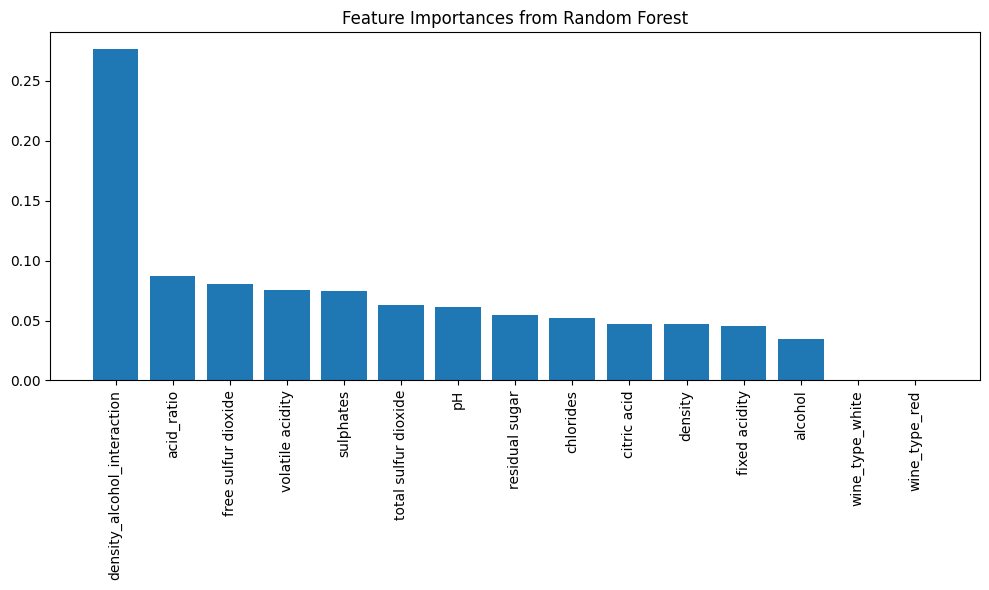

In [14]:
# Feature Importance (from Random Forest)
# ----------------------------
feature_names = (
    numeric_features +
    list(best_model.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out(categorical_features))
)

importances = best_model.named_steps['regressor'].feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_idx])
plt.xticks(range(len(importances)), np.array(feature_names)[sorted_idx], rotation=90)
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
plt.show()

In [19]:
# Save the Best Model
# ----------------------------
joblib.dump(best_model, "models/best_regressor.pkl")
print("Best model saved to models/best_regressor.pkl")

Best model saved to models/best_regressor.pkl
